# comparison against high-res GEMINI/GHOST spectra

see [issue](https://github.com/galactic-ai/SpenderQ/issues/18)

The GHOST Spectrum has TARGETID=39627775732093815

In [1]:
import os
import pickle
import numpy as np
import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

# find TARGETID

In [3]:
ghost_id = 39627775732093815

In [4]:
niter = 3 

for ibatch in range(85): 
    with open('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    
    if ghost_id in target_id: 
        print('GHOST SPECTRUM is in BATCH %i' % ibatch)
        break 

GHOST SPECTRUM is in BATCH 15


In [5]:
igal = np.arange(len(target_id))[np.array(target_id) == ghost_id][0]

# load `SpenderQ` models

In [6]:
niter = 3 

models = [] 
for imodel in range(5): 
    # load model
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.edr.hiz.sa1p5sb1p5.i%i.%i.pt' % (niter, imodel))
    models.append(_models[0])

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


## load matching `SpenderQ` reconstructions

In [7]:
wave_obs = np.array(models[0].wave_obs)
w_recon = np.array(models[0].wave_rest) # reconstruciton rest-frame wavelength 

recons = [] 
for imodel in range(5): 
    frecon = '/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % (niter, imodel, ibatch)
    flatent = '/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.latents.npy' % (niter, imodel, ibatch)
    if os.path.isfile(frecon): 
        recon = np.load(frecon)
    else: 
        with torch.no_grad():
            models[imodel].eval()

            s = models[imodel].encode(spec)
            recon = np.array(models[imodel].decode(s))
            
        np.save(flatent, s)
        np.save(frecon, recon)
    recons.append(recon)
    
recons = np.array(recons)    

# some demos of `SpenderQ`

/tmp/ipykernel_2117349/772896345.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


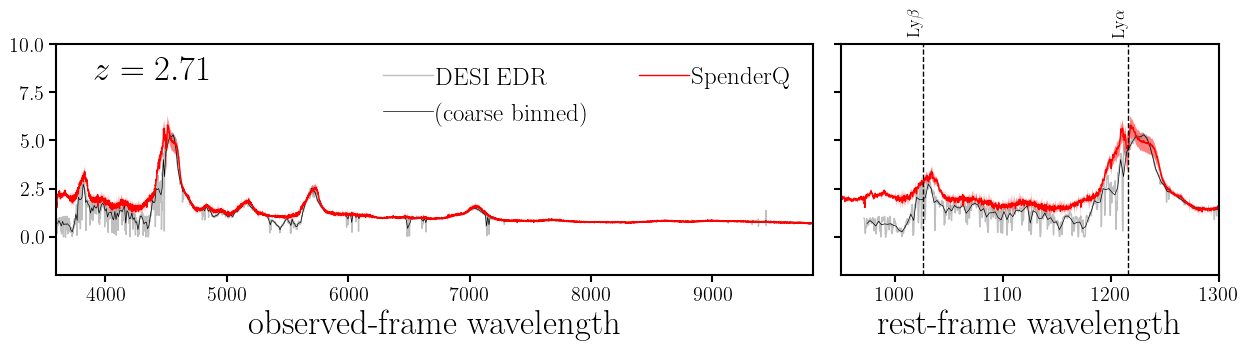

In [8]:
fig = plt.figure(figsize=(15,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# observed-frame full spectra
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]

sub = plt.subplot(gs[0])

# full spectra
sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='DESI EDR')

# coarse spectra
spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
sub.plot(wave_rebin, spec_rebin, c='k', lw=0.5, label='(coarse binned)')

# spenderq recon
sub.fill_between(models[0].wave_rest * (1+z[igal]), 
                 np.min(recons[:,igal,:], axis=0), 
                 np.max(recons[:,igal,:], axis=0), color='r', edgecolor='None', alpha=0.5)
sub.plot(models[0].wave_rest * (1+z[igal]), np.mean(recons[:,igal,:], axis=0), color='r', lw=1, label=r'SpenderQ')    

# redshift
sub.text(0.05, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
sub.legend(loc='upper right', ncol=2, fontsize=18, handletextpad=0.1)
sub.set_ylim(-2, 10.)
sub.set_xlabel("observed-frame wavelength", fontsize=25)

# zoom in rest-frame LyA region 
sub = plt.subplot(gs[1])    
sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='DESI')
#sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=0.5)

# spenderq
sub.fill_between(models[0].wave_rest, 
             np.min(recons[:,igal,:], axis=0), 
             np.max(recons[:,igal,:], axis=0), color='r', edgecolor='None', alpha=0.5)
sub.plot(models[0].wave_rest, np.mean(recons[:,igal,:], axis=0), color='r', lw=1, label=r'SpenderQ')    


sub.axvline(1026, color='k', linewidth=1, linestyle='--')
sub.axvline(1216, color='k', linewidth=1, linestyle='--')

sub.text(1026, 11.8, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 11.8, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_ylim(-2, 10.)
sub.set_yticklabels([])
    
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1, wspace=0.05)
#plt.savefig('spenderq_edr_demo.pdf', bbox_inches='tight')

# save spenderq reconstruction

In [20]:
np.savetxt('ghost.spenderq_recon.dat', np.vstack([np.array(models[0].wave_rest), 
                      np.mean(recons[:,igal,:], axis=0) * float(norm[igal]), 
                      np.min(recons[:,igal,:], axis=0) * float(norm[igal]), 
                      np.max(recons[:,igal,:], axis=0) * float(norm[igal])]).T, 
          header="lambda, mean recon, min recon, max recon")